# Gastos por Categoría 2026

In [1]:
import sys

# Añadimos al path la ruta del código fuente para poder usar
# la conexión a la base de datos
sys.path.append('../src')
from db.connection import ConexionBD

import pandas as pd
import os

import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [2]:
conn = ConexionBD.obtener_conexion()

In [11]:
# Gastos 2025
query = """
    SELECT fecha_valor, importe, saldo, categoria, subcategoria, descripcion
    FROM bancapp.movimientos_mview
    WHERE fecha_valor between '2026-01-01' and '2026-01-31'
    ORDER BY fecha_valor
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

# Creamos el data frame de gastos
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria", 
                              "subcategoria", "descripcion"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

# Creamos categorias
df_gastos["categoria"] = df_gastos["categoria"].astype("category")
df_gastos["subcategoria"] = df_gastos["subcategoria"].astype("category") 

# Quitamos los gastos de la obra de los baños
df_gastos = df_gastos[df_gastos.importe < 2000]

df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 88
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   76 non-null     datetime64[ns]
 1   mes_valor     76 non-null     int32         
 2   anio_valor    76 non-null     int32         
 3   importe       76 non-null     float64       
 4   categoria     76 non-null     category      
 5   subcategoria  76 non-null     category      
 6   descripcion   76 non-null     object        
dtypes: category(2), datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ KB


In [12]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 0 to 88
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   fecha_valor   76 non-null     datetime64[ns]
 1   mes_valor     76 non-null     int32         
 2   anio_valor    76 non-null     int32         
 3   importe       76 non-null     float64       
 4   categoria     76 non-null     category      
 5   subcategoria  76 non-null     category      
 6   descripcion   76 non-null     object        
dtypes: category(2), datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 4.2+ KB


**Media de gasto mensual**

In [13]:
dfg = df_gastos.groupby("mes_valor").agg(total=("importe","sum"))

media_mensual = dfg.total.mean()

print(f"Gasto medio mensual: {media_mensual:.2f}")

Gasto medio mensual: 6213.00


**Gasto medio mensual por categoria**

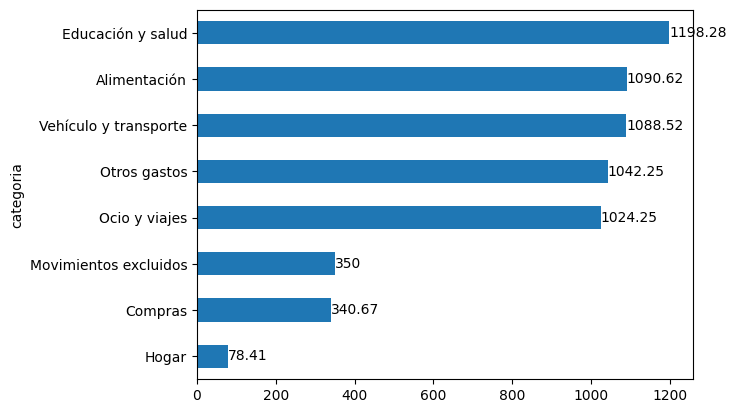

In [14]:
dfg = df_gastos.groupby(["mes_valor","categoria"], observed=True).agg(total=("importe","sum"))
pivot = dfg.total.unstack(fill_value=0)
ax = pivot.mean().sort_values().plot(kind="barh");
ax.bar_label(ax.containers[0]);

**Listado de categorías**

In [15]:
df_gastos.categoria.cat.categories

Index(['Alimentación', 'Compras', 'Educación y salud', 'Hogar',
       'Movimientos excluidos', 'Ocio y viajes', 'Otros gastos',
       'Vehículo y transporte'],
      dtype='object')

**Gastos por categoría**

Agrupamnos por categoria

In [16]:
dfg = df_gastos.groupby("categoria",observed=True).agg(total=("importe","sum"))

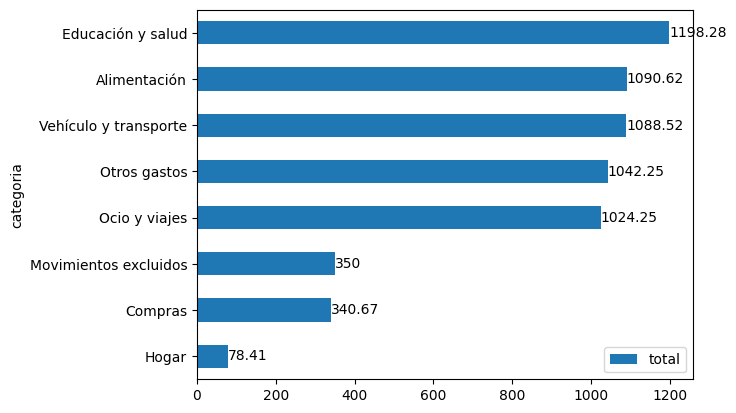

In [17]:
ax = dfg.sort_values(by="total").plot(kind="barh")
ax.bar_label(ax.containers[0]);

**Gasto mensual por categoría**

In [18]:
# Función reutilizable por categoría
def gasto_mes_categoria(categoria:str):

    dfg = df_gastos[df_gastos.categoria==categoria].groupby("mes_valor").agg(total=("importe","sum"))

    #calculate mean
    mean_val = dfg.total.mean()

    # Plot the group
    ax = dfg.plot(kind="bar");
    
    # Plot Línea de media
    ax.axhline(y=mean_val, color="red", label=f'Media: {mean_val:.0f}');
    
    # Plot Etiquetas dee las barras
    ax.bar_label(ax.containers[0]);
    
    plt.title(f"Gasto {categoria} por mes 2025")
    plt.legend()
    plt.show()

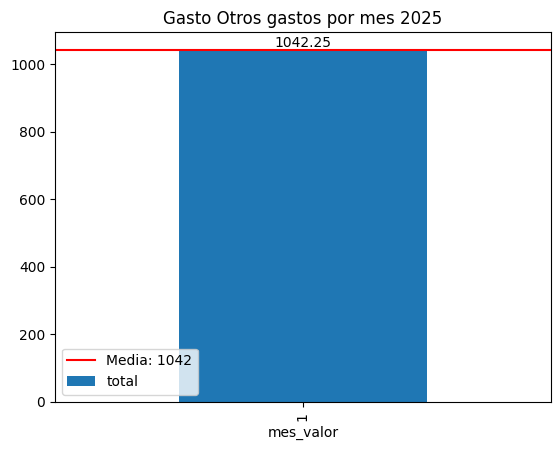

In [19]:
gasto_mes_categoria("Otros gastos")

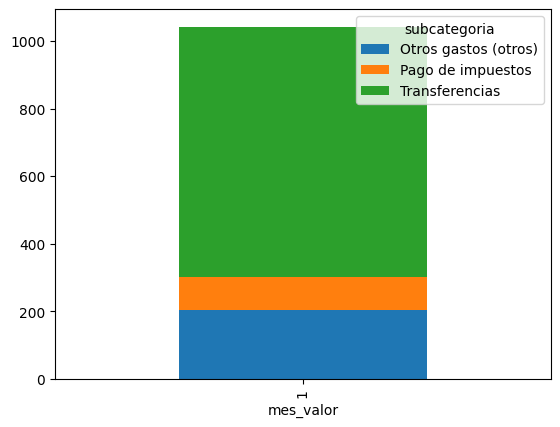

In [20]:
dfg = df_gastos[df_gastos.categoria=="Otros gastos"] \
    .groupby(["mes_valor", "subcategoria"], observed=True) \
    .agg(total=("importe","sum"))

pivot = dfg.total.unstack(fill_value=0)

pivot.plot(kind="bar", stacked=True);

In [21]:
df_gastos.subcategoria.cat.categories

Index(['Cafeterías y restaurantes', 'Compras (otros)', 'Dentista, médico',
       'Deporte y gimnasio', 'Educación', 'Gasolina y combustible',
       'Hotel y alojamiento', 'Libros, música y videojuegos', 'Luz y gas',
       'Otros gastos (otros)', 'Pago de impuestos', 'Peajes',
       'Regalos y juguetes', 'Ropa y complementos', 'Seguro de coche y moto',
       'Supermercados y alimentación', 'Teléfono, TV e internet',
       'Transferencias', 'Traspaso entre cuentas'],
      dtype='object')

In [22]:
df_gastos[(df_gastos.categoria=="Otros gastos") & (df_gastos.subcategoria=="Transferencias")] \
    .sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion
17,2026-01-04,1,2026,462.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
50,2026-01-11,1,2026,145.0,Otros gastos,Transferencias,Transferencia emitida a PSICOLOGIA Y LOGOPEDIA...
5,2026-01-02,1,2026,75.0,Otros gastos,Transferencias,Transferencia emitida periódica
78,2026-01-24,1,2026,35.0,Otros gastos,Transferencias,Transferencia emitida a CARLOS ANTONIO PEREZ H...
86,2026-01-30,1,2026,25.0,Otros gastos,Transferencias,Transferencia emitida a MCARMEN LOPEZ GUIJARRO...


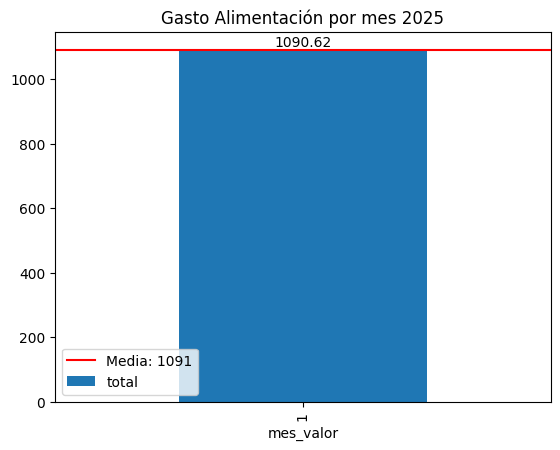

In [23]:
gasto_mes_categoria("Alimentación")

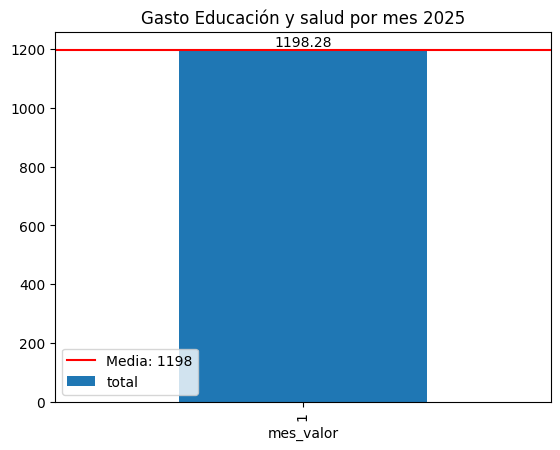

In [24]:
gasto_mes_categoria("Educación y salud")

Revisar gastos de noviembre

In [25]:
df_gastos[(df_gastos.categoria=="Educación y salud") & (df_gastos.mes_valor==11)].sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion


Agrupamos por subcategoría y pivotamos para revisar visualemente

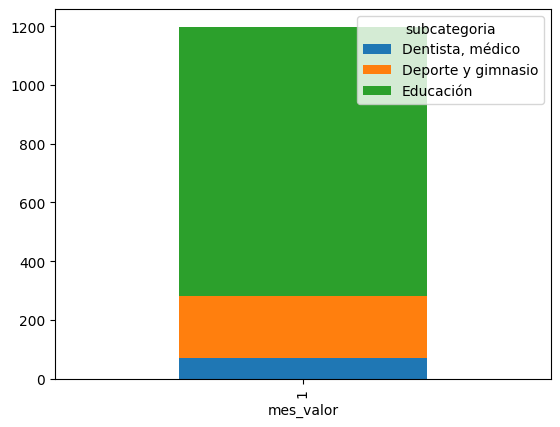

In [29]:
# Agrupamos por mes y subcategoria
dfg = df_gastos[df_gastos.categoria=="Educación y salud"] \
    .groupby(["mes_valor", "subcategoria"], observed=True) \
    .agg(total=("importe","sum"))

# Obtenemos la seria, que tiene multi-index (mes y subcategoria) y pivotamos por subcategoria, para llevarlo a columnas y poder apilar
dfg_pivot = dfg["total"].unstack().fillna(0)

dfg_pivot.plot(kind="bar", stacked=True)

plt.show()

**Compras**

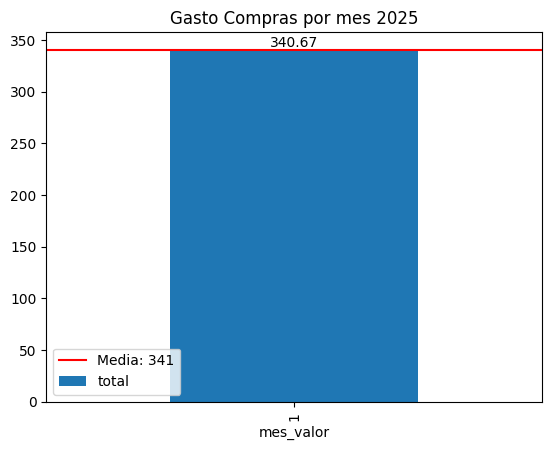

In [30]:
gasto_mes_categoria("Compras")

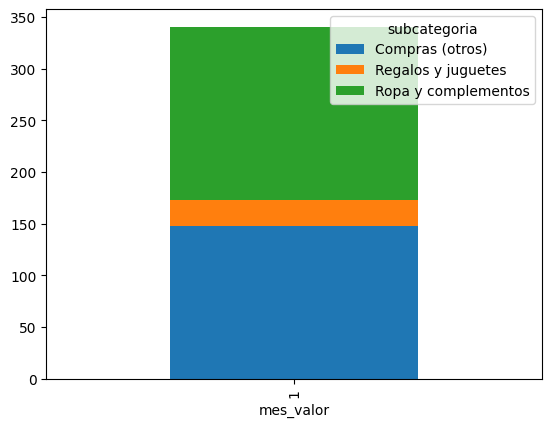

In [34]:
dfg = df_gastos[df_gastos.categoria=="Compras"] \
    .groupby(["mes_valor", "subcategoria"], observed=True) \
    .agg(total=("importe","sum"))
pivot = dfg["total"].unstack(fill_value=0)

ax = pivot.plot(kind="bar", stacked=True)

Revisamos las compras de octubre

In [35]:
df_gastos[(df_gastos.categoria=="Compras") & (df_gastos.mes_valor==10)].sort_values(by="importe", ascending=False)

,fecha_valor,mes_valor,anio_valor,importe,categoria,subcategoria,descripcion
